## Практическое задание к уроку № 4 по теме "Деревья решений".

#### Задание 1.  
*В коде из методички реализуйте один или несколько критериев останова: минимальное количество объектов в листе (`min_leaf`),  
максимальная глубина дерева, максимальное количество листьев и т.д. Добавьте эти критерии в параметры функции `build_tree`  
и проверьте ее работоспособность с помощью визуализации дерева.* 

#### Задание 2*.  
*Для задачи классификации обучите дерево решений с использованием критериев разбиения Джини и Энтропия.  
Сравните качество классификации, сделайте выводы.*  

#### Задание 3*.  
*Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке,  
заменив механизм предсказания в листе на взятие среднего значения по выборке, а критерий Джини на дисперсию значений.  
Проверьте точность предсказания дерева на одной из метрик задачи регрессии.*

Перепишем код с урока в ООП-виде и внесём в него требуемые изменения для всех трёх заданий:

In [1]:
%matplotlib inline

from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, model_selection

In [2]:
class DecisionTree:
    
    def __init__(self, data, labels, criterion='gini', min_leaf=5, max_depth=3):
        
        self.tree = self.build_tree(data, labels, criterion, min_leaf, max_depth)
        self.criterion = criterion
    
    class Node:
        
        def __init__(self, index, t, true_branch, false_branch):
            
            self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
            self.t = t  # значение порога
            self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
            self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле
    
    class Leaf:
        
        def __init__(self, data, labels, criterion):
            
            self.data = data
            self.labels = labels
            self.criterion = criterion
            self.prediction = self.predict()
    
        def predict(self):
            
            if self.criterion == 'regression':
                return self.labels.mean()
            
            else:
                classes = Counter(self.labels)
                return max(classes, key=classes.get)
            
    # Расчет критерия информативности
    def impurity_criterion(self, labels, criterion):
        
        if criterion == 'gini':
            classes = Counter(labels)
            impurity = 1
            for label in classes:
                p = classes[label] / len(labels)
                impurity -= p ** 2
                
        elif criterion == 'entropy':
            classes = Counter(labels)
            impurity = 0
            for label in classes:
                p = classes[label] / len(labels)
                impurity -= p * np.log2(p) if p != 0 else 0
        
        elif criterion == 'regression':
            impurity = ((labels - labels.mean())**2).sum() / labels.shape[0]
        
        return impurity
    
    # Расчет качества
    def quality(self, left_labels, right_labels, criterion, current_criterion):
        
        # доля выборки, ушедшая в левое поддерево
        p = left_labels.shape[0] / (left_labels.shape[0] + right_labels.shape[0])
        
        return current_criterion - p * self.impurity_criterion(left_labels, criterion) - (1 - p) * self.impurity_criterion(right_labels, criterion)
    
    # Разбиение датасета в узле
    def split(self, data, labels, index, t):
        
        left = np.where(data[:, index] <= t)
        right = np.where(data[:, index] > t)

        true_data = data[left]
        false_data = data[right]
        true_labels = labels[left]
        false_labels = labels[right]
        
        return true_data, false_data, true_labels, false_labels
    
    # Нахождение наилучшего разбиения
    def find_best_split(self, data, labels, criterion, min_leaf):
        
        current_criterion = self.impurity_criterion(labels, criterion)
        
        best_quality = 0
        best_t = None
        best_index = None
    
        n_features = data.shape[1]
    
        for index in range(n_features):
            
            # будем проверять только уникальные значения признака, исключая повторения
            t_values = np.unique(data[:, index])

            for t in t_values:
                true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)
                
                #  пропускаем разбиения, в которых в узле остается менее min_leaf объектов
                if len(true_data) < min_leaf or len(false_data) < min_leaf:
                    continue
                    
                current_quality = self.quality(true_labels, false_labels, criterion, current_criterion)
                
                #  выбираем порог, на котором получается максимальный прирост качества
                if current_quality > best_quality:
                    best_quality, best_t, best_index = current_quality, t, index
        
        return best_quality, best_t, best_index
    
    # Построение дерева с помощью рекурсивной функции
    def build_tree(self, data, labels, criterion, min_leaf, max_depth):
        
        quality, t, index = self.find_best_split(data, labels, criterion, min_leaf)
    
        #  Базовый случай - прекращаем рекурсию, когда нет прироста качества
        #  или достигнут критерий останова

        if (max_depth == 0) or (quality == 0):
            return self.Leaf(data, labels, criterion)
        
        true_data, false_data, true_labels, false_labels = self.split(data, labels, index, t)
        
        # Рекурсивно строим два поддерева, обращая внимание на критерий останова
        true_branch = self.build_tree(true_data, true_labels, criterion, min_leaf, max_depth=max_depth-1)
        false_branch = self.build_tree(false_data, false_labels, criterion, min_leaf, max_depth=max_depth-1)
        
        # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
        return self.Node(index, t, true_branch, false_branch)
    
    def predict_object(self, obj, node):

        #  Останавливаем рекурсию, если достигли листа
        if isinstance(node, self.Leaf):
            answer = node.prediction
            return answer

        if obj[node.index] <= node.t:
            return self.predict_object(obj, node.true_branch)
        else:
            return self.predict_object(obj, node.false_branch)
    
    def predict(self, data):
        
        if self.criterion == 'regression':
            return [self.predict_object(obj, self.tree) for obj in data]
        
        else:
            classes = []
            for obj in data:
                prediction = self.predict_object(obj, self.tree)
                classes.append(prediction)
            return classes

Создадим датасет для проверки алгоритма:

In [3]:
classification_data, classification_labels = datasets.make_classification(n_samples=1000, n_features=2, n_informative=2, 
                                                      n_classes=2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=29)

Разобъём на обучающую и тестовую выборки:

In [4]:
train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

Обучим дерево решений и сделаем предсказания на обеих выборках:

In [5]:
model = DecisionTree(train_data, train_labels, criterion='gini', min_leaf=10, max_depth=4)

In [6]:
train_answers = model.predict(train_data)

In [7]:
answers = model.predict(test_data)

In [8]:
class ColorText:
    RED = '\033[1;31;48m'
    CYAN = '\033[1;36;48m'
    END = '\033[1;37;0m'

In [9]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, DecisionTree.Leaf):
        print(ColorText.CYAN + spacing + ' ЛИСТ' 
                  + ': прогноз = ' + str(node.prediction) 
                  + ', объектов = ' + str(len(node.labels)) 
                  + ColorText.END)
        return

    # Выведем значение индекса и порога на этом узле
    print(ColorText.RED + spacing + ' УЗЕЛ'  
              + ': индекс = ' + str(node.index) 
              + ', порог = ' + str(round(node.t, 2))
              + ColorText.END)

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> Левая ветка:')
    print_tree(node.true_branch, spacing + "   ")

    # Рекурсионный вызов функции на отрицательном поддереве
    print (spacing + '--> Правая ветка:')
    print_tree(node.false_branch, spacing + "   ")

In [10]:
print_tree(model.tree)

 УЗЕЛ: индекс = 1, порог = 0.07
--> Левая ветка:
    УЗЕЛ: индекс = 0, порог = 2.41
   --> Левая ветка:
       УЗЕЛ: индекс = 1, порог = -0.72
      --> Левая ветка:
          УЗЕЛ: индекс = 0, порог = 1.62
         --> Левая ветка:
             ЛИСТ: прогноз = 0, объектов = 187
         --> Правая ветка:
             ЛИСТ: прогноз = 0, объектов = 53
      --> Правая ветка:
          УЗЕЛ: индекс = 0, порог = 1.04
         --> Левая ветка:
             ЛИСТ: прогноз = 0, объектов = 77
         --> Правая ветка:
             ЛИСТ: прогноз = 1, объектов = 39
   --> Правая ветка:
       ЛИСТ: прогноз = 1, объектов = 12
--> Правая ветка:
    УЗЕЛ: индекс = 0, порог = 0.65
   --> Левая ветка:
       УЗЕЛ: индекс = 1, порог = 0.68
      --> Левая ветка:
          УЗЕЛ: индекс = 0, порог = 0.35
         --> Левая ветка:
             ЛИСТ: прогноз = 0, объектов = 17
         --> Правая ветка:
             ЛИСТ: прогноз = 0, объектов = 26
      --> Правая ветка:
          УЗЕЛ: индекс = 1, поро

#### Задание 2.

In [11]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    
    correct = (predicted == actual).sum()

    return correct / len(actual) * 100.0

Обучим модель с теми же параметрами, но используя энтропию Шеннона вместо критерия Джини:

In [12]:
model_entropy = DecisionTree(train_data, train_labels, criterion='entropy', min_leaf=10, max_depth=4)

In [13]:
train_answers_entropy = model_entropy.predict(train_data)

In [14]:
answers_entropy = model_entropy.predict(test_data)

Сравним метрики accuracy обоих алгоритмов на обучающей и тестовой выборках:

In [15]:
print(f'Метрики модели с критерием Джини:\n'
      f'Train: {accuracy_metric(train_labels, train_answers):.2f}\tTest: {accuracy_metric(test_labels, answers):.2f}\n')
print(f'Метрики модели с энтропийным критерием:\n'
      f'Train: {accuracy_metric(train_labels, train_answers_entropy):.2f}\tTest: {accuracy_metric(test_labels, answers_entropy):.2f}')

Метрики модели с критерием Джини:
Train: 91.14	Test: 88.00

Метрики модели с энтропийным критерием:
Train: 90.71	Test: 87.67


Модель с критерием информативности Джини показала более высокую метрику при тех же параметрах.

#### Задание 3.

Дан датасет:

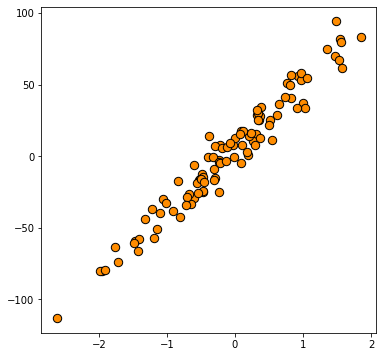

In [16]:
regression_data, regression_labels = datasets.make_regression(n_samples=100, 
                                                      n_features=1, bias=5, noise=10,
                                                      random_state=42)
plt.figure(figsize=(6,6))
plt.scatter(regression_data, regression_labels, c='darkorange', edgecolor='black', s=70)

plt.show()

Разобъём на обучающую и тестовую выборки:

In [17]:
train_data_reg, test_data_reg, train_labels_reg, test_labels_reg = model_selection.train_test_split(regression_data, 
                                                                                                    regression_labels, 
                                                                                                    test_size = 0.3,
                                                                                                    random_state = 1)

Обучим модель и изобразим дерево решений:

In [18]:
model_regression = DecisionTree(train_data_reg, train_labels_reg, criterion='regression', min_leaf=3, max_depth=4)

In [19]:
print_tree(model_regression.tree)

 УЗЕЛ: индекс = 0, порог = 0.09
--> Левая ветка:
    УЗЕЛ: индекс = 0, порог = -1.15
   --> Левая ветка:
       УЗЕЛ: индекс = 0, порог = -1.72
      --> Левая ветка:
          ЛИСТ: прогноз = -78.39843636417893, объектов = 4
      --> Правая ветка:
          УЗЕЛ: индекс = 0, порог = -1.41
         --> Левая ветка:
             ЛИСТ: прогноз = -61.06062387770854, объектов = 4
         --> Правая ветка:
             ЛИСТ: прогноз = -50.703542068242065, объектов = 3
   --> Правая ветка:
       УЗЕЛ: индекс = 0, порог = -0.46
      --> Левая ветка:
          УЗЕЛ: индекс = 0, порог = -0.6
         --> Левая ветка:
             ЛИСТ: прогноз = -31.059947905776482, объектов = 8
         --> Правая ветка:
             ЛИСТ: прогноз = -17.82218541713025, объектов = 8
      --> Правая ветка:
          УЗЕЛ: индекс = 0, порог = -0.23
         --> Левая ветка:
             ЛИСТ: прогноз = -2.073890167233853, объектов = 6
         --> Правая ветка:
             ЛИСТ: прогноз = 2.8772350966915217

In [20]:
train_answers_reg = model_regression.predict(train_data_reg)

In [21]:
answers_reg = model_regression.predict(test_data_reg)

Напишем функцию метрики для регрессии:

In [22]:
def calc_r2(y_pred, y):
    return 1 - ((y_pred - y)**2).sum() / ((y - y.mean())**2).sum()

Посчитаем метрики на обучающей и тестовой выборках:

In [23]:
print(f'Метрики R2 модели регрессии:\n'
      f'Train: {calc_r2(train_answers_reg, train_labels_reg):.2f}\tTest: {calc_r2(answers_reg, test_labels_reg):.2f}')

Метрики R2 модели регрессии:
Train: 0.97	Test: 0.89


Изобразим предсказания модели на графике вместе с исходными данными:

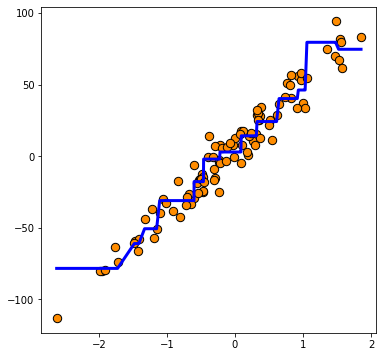

In [24]:
X = sorted(regression_data)
Y = model_regression.predict(X)

plt.figure(figsize=(6,6))
plt.scatter(regression_data, regression_labels, c='darkorange', edgecolor='black', s=70)
plt.plot(X, Y, lw=3, color='blue')

plt.show()